In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os import path
import sys
sys.path.insert(0, path.abspath('../'))

from src.mcmc import Chain
from src import parse_model_parameter_file

In [3]:
def read_pkl_file_chain(PATH_pklfile_chains):
    with open(PATH_pklfile_chains, 'rb') as pf:
        data = pickle.load(pf)
    
    chain = data['chain']

    n_walkers = chain.shape[0]
    n_steps = chain.shape[1]
    n_parameters = chain.shape[2]

    return n_walkers, n_steps, n_parameters, data['chain']

In [5]:
#loading the chain file

dNcencut = 7  
vncencut = 6

nameStr = "AllRHIC_wCov"

chain_pkl = read_pkl_file_chain(path.join("mcmc", "chain.pkl"))[3]

chain = np.nan_to_num(chain_pkl)

FileNotFoundError: [Errno 2] No such file or directory: 'mcmc/chain.pkl'

In [55]:
# get the posterior parameters

nwalkers, nsteps, ndim = chain.shape

samples = chain.reshape(-1, ndim)

# print out the MAP parameters

results = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
              zip(*np.percentile(samples, [16, 50, 84], axis=0)))
mapParam = []
for ipar, par in enumerate(list(results)):
    print("%s = %.4f^{+%.4f}_{-%.4f}" % (
        ipar, par[0], par[1], par[2]))
    mapParam.append(par[0])

# define the relevant mcmc object
exp_path = "./separate_training_posterior_data_1095/example_data_test_point1099.pkl"
model_par = "../data/modelDesign_3DMCGlauber.txt"
mymcmc = Chain(expdata_path=exp_path, model_parafile=model_par)

folder = "./trained_emulators_wPosterior/"
emuPathList = [folder+"AuAu200_dNdy_train_noPCA_noLOG_PCSK_trained.sav",
               folder+"AuAu200_pTvn_train_noPCA_noLOG_PCSK_trained.sav",
               folder+"AuAu200_PHOBOSdNdeta_train_noPCA_noLOG_PCSK_trained.sav",
               folder+"AuAu200_PHOBOSv2eta_train_noPCA_noLOG_PCSK_trained.sav",
               folder+"AuAu19p6_dNdy_train_noPCA_noLOG_PCSK_trained.sav",
               folder+"AuAu19p6_pTvn_train_noPCA_noLOG_PCSK_trained.sav",
               folder+"AuAu19p6_PHOBOSdNdeta_train_noPCA_noLOG_PCSK_trained.sav",
               folder+"AuAu7.7_dNdy_train_noPCA_noLOG_PCSK_trained.sav",
               folder+"AuAu7.7_pTvn_train_noPCA_noLOG_PCSK_trained.sav",
               ]
mymcmc.loadEmulator(emuPathList)



(1000, 1000, 20)
0 = 20.3032^{+1.6919}_{-1.9746}
1 = 0.0697^{+0.0578}_{-0.0382}
2 = 1.3404^{+0.0600}_{-0.0613}
3 = 1.8143^{+0.0968}_{-0.0913}
4 = 2.2512^{+0.1275}_{-0.1241}
5 = 0.3067^{+0.0565}_{-0.0540}
6 = 0.7806^{+0.0396}_{-0.0516}
7 = 0.1867^{+0.0387}_{-0.0310}
8 = 0.1509^{+0.0140}_{-0.0131}
9 = 0.1979^{+0.0186}_{-0.0162}
10 = 0.6576^{+0.1260}_{-0.0991}
11 = 0.3606^{+0.0900}_{-0.0670}
12 = 0.1439^{+0.0228}_{-0.0215}
13 = 0.2046^{+0.0232}_{-0.0202}
14 = 0.1883^{+0.0408}_{-0.0461}
15 = 0.0922^{+0.0109}_{-0.0092}
16 = 0.2351^{+0.0049}_{-0.0057}
17 = 0.0873^{+0.0242}_{-0.0155}
18 = 0.0744^{+0.0056}_{-0.0076}
19 = 0.3450^{+0.0219}_{-0.0189}
[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.h5
[INFO][mcmc] Loading the model parameters space from ../data/modelDesign_3DMCGlauber.txt ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from ./separate_training_posterior_data_1095/example_data_test_point1099.pkl

In [53]:
#%% setup the MCMC Chain
rng = np.random.default_rng()
sampleIdxList = rng.choice(samples.shape[0], 15, replace=False)
posteriorSamples = samples[sampleIdxList, :]

postPred = mymcmc._predict(posteriorSamples)
postPred = postPred[0].transpose()
nsamples = postPred.shape[1]

expData = mymcmc._read_in_exp_data_pickle(exp_path)

[INFO][mcmc] Training dataset size: 1


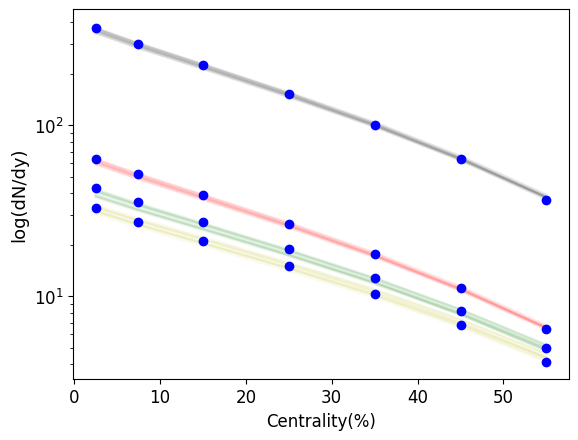

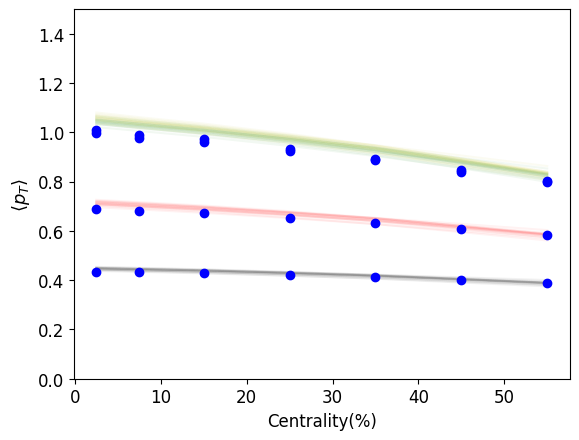

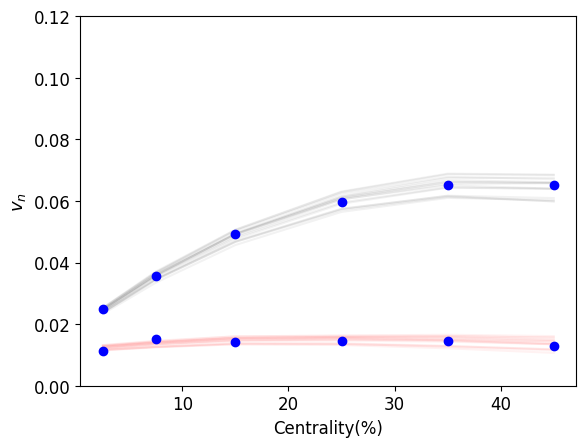

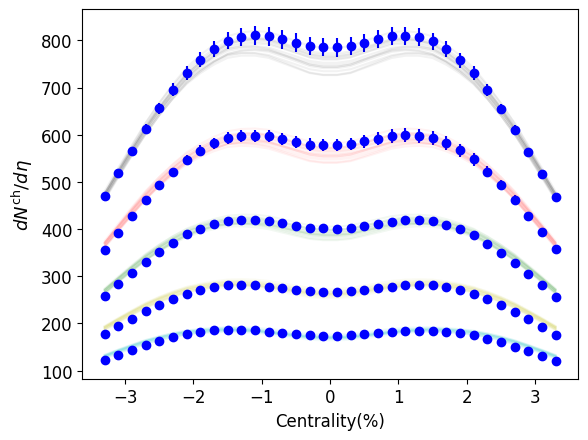

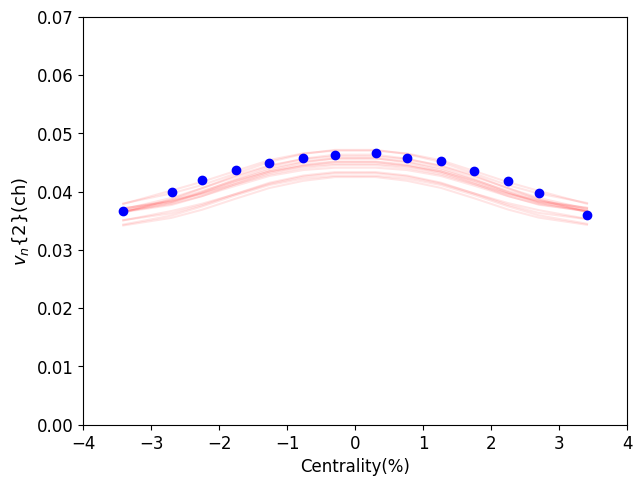

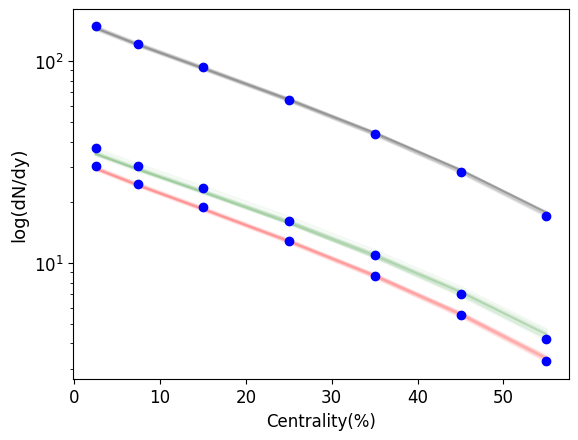

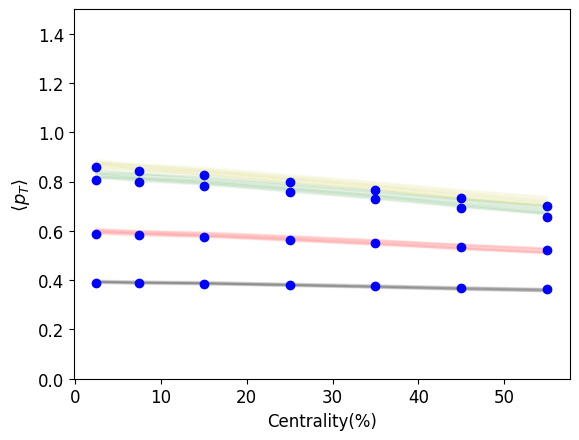

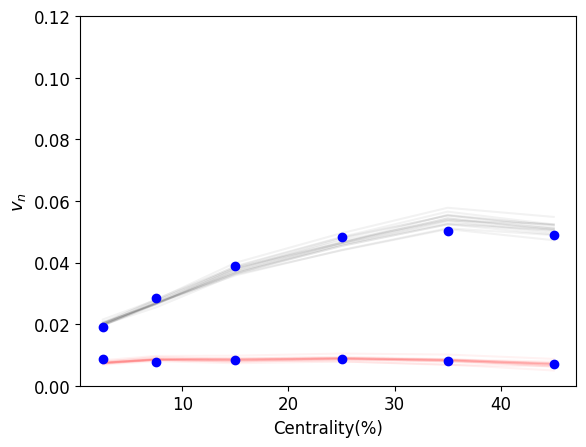

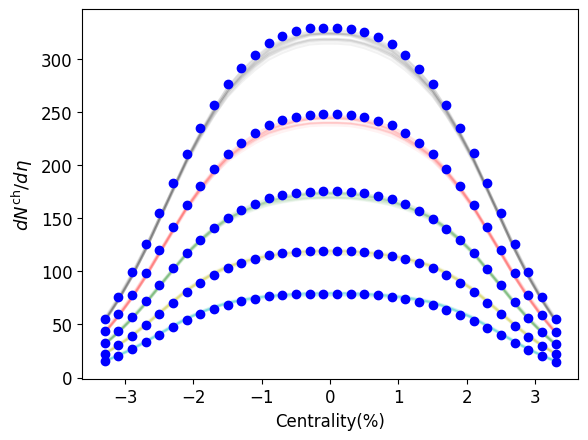

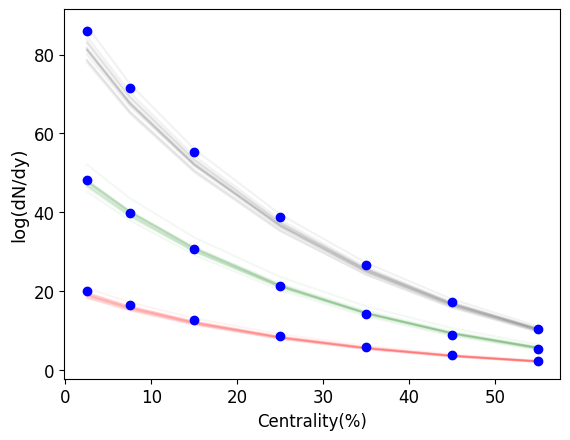

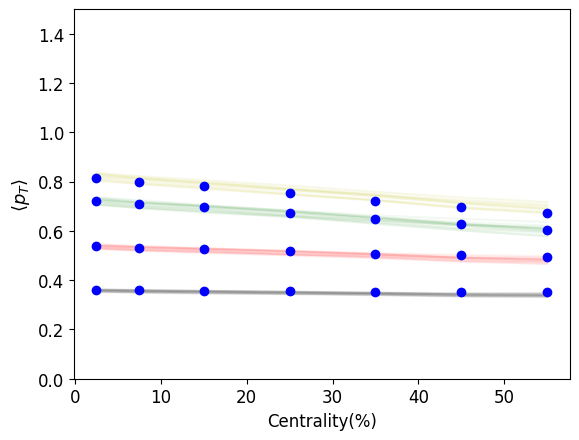

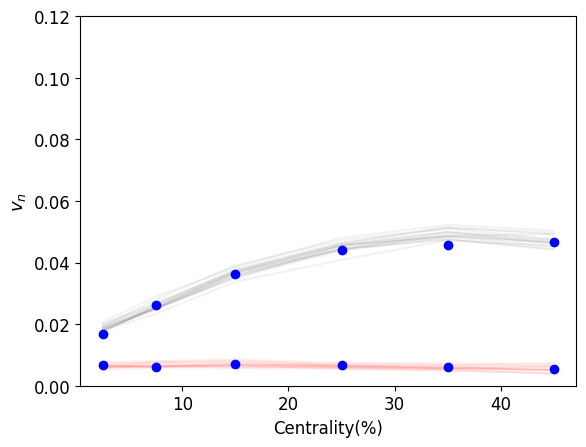

In [54]:
#the closure test plotting functions

colorList = ['k', 'r', 'g', 'y', 'c']
cenList = np.array([2.5, 7.5, 15, 25, 35, 45, 55, 65, 75, 85, 95])

# dN/dy
fig = plt.figure()
for ipart in range(4):
    plt.errorbar(cenList[:dNcencut],
                 expData[0][:, ipart*dNcencut:(ipart+1)*dNcencut].flatten(),
                 expData[1][ipart*dNcencut:(ipart+1)*dNcencut, ipart*dNcencut:(ipart+1)*dNcencut].diagonal(),
                 marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:dNcencut],
                 postPred[ipart*dNcencut:(ipart+1)*dNcencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.yscale('log')
plt.xlabel("Centrality(%)", fontsize = 12)
plt.ylabel("log(dN/dy)", fontsize = 13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("dNdy200_{}.pdf".format(nameStr))

# mean pT
offset = 4*dNcencut
fig = plt.figure()
for ipart in range(4):
    plt.errorbar(cenList[:dNcencut],
                 expData[0][:, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
                 expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
                 marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:dNcencut],
                 postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.ylim([0, 1.5])
plt.xlabel("Centrality(%)", fontsize = 12)
plt.ylabel(r"$\langle p_T \rangle$", fontsize = 13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("meanpT200_{}.pdf".format(nameStr))

# vn
offset += 4*dNcencut
fig = plt.figure()
for ipart in range(2):
    plt.errorbar(cenList[:vncencut],
             expData[0][:, offset+ipart*vncencut:offset+(ipart+1)*vncencut].flatten(),
             expData[1][offset+ipart*vncencut:offset+(ipart+1)*vncencut].diagonal(),
             marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:vncencut],
                 postPred[offset+ipart*vncencut:offset+(ipart+1)*vncencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.ylabel(r"$v_n$", fontsize = 13 )
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim([0., 0.12])
plt.savefig("vn200_{}.pdf".format(nameStr))

# dNdeta
Nrap = 34 #possibly 34
rapArr = np.linspace(-3.3, 3.3, Nrap) #rapidity range different for current simulation, -3.3 to 3.3
offset += 2*vncencut
fig = plt.figure()
for ipart in range(5):
    plt.errorbar(rapArr,
             expData[0][:,offset+ipart*Nrap:offset+(ipart+1)*Nrap].flatten(),
             expData[1][offset+ipart*Nrap:offset+(ipart+1)*Nrap, offset+ipart*Nrap:offset+(ipart+1)*Nrap].diagonal(),
             marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(rapArr,
                 postPred[offset+ipart*Nrap:offset+(ipart+1)*Nrap, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)

plt.ylabel(r"$dN^{\rm ch}/d\eta$", fontsize = 13)       
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("dNdeta200_{}.pdf".format(nameStr))

# v2(eta)
offset += 5*Nrap
v2rapArr = np.array([-4.90, -4.16, -3.41, -2.70, -2.25, -1.75, -1.26, -0.76,
                     -0.3, 0.3, 0.76, 1.26, 1.75, 2.25, 2.70, 3.41, 4.16, 4.94])
v2Nrap = v2rapArr.shape[0] - 4

fig = plt.figure()
ax = plt.axes([0.12, 0.12, 0.85, 0.85])
plt.errorbar(v2rapArr[2:-2],
             expData[0][:, offset : (offset+v2Nrap)].flatten(),
             expData[1][offset:offset+v2Nrap, offset:offset+v2Nrap].diagonal(),
             marker='o', color='b', linestyle='')
for i in range(nsamples):
    plt.plot(v2rapArr[2:-2],
             postPred[offset:offset+v2Nrap, i],
             linestyle='-', color=colorList[1], alpha=0.1)
#for i in range(1):
#    plt.fill_between(
#        rapArr,
#        postPred[offset:offset+Nrap, i] + postPredErr[offset:offset+Nrap, i],
#        postPred[offset:offset+Nrap, i] - postPredErr[offset:offset+Nrap, i],
#        color=colorList[1], alpha=0.05)
plt.xlim([-4, 4])
plt.ylim([0, 0.07])
plt.ylabel(r"$v_n\{2\}({\rm ch})$", fontsize = 13)       
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("v2eta200_{}.pdf".format(nameStr))

# dN/dy
offset += v2Nrap
fig = plt.figure()
for ipart in range(3):
    plt.errorbar(cenList[:dNcencut],
                 expData[0][:, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
                 expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
                 marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:dNcencut],
                 postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.yscale('log')
plt.ylabel("log(dN/dy)", fontsize = 13)       
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("dNdy19p6_{}.pdf".format(nameStr))

# mean pT
offset += 3*dNcencut
fig = plt.figure()
for ipart in range(4):
    plt.errorbar(cenList[:dNcencut],
                 expData[0][:, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
                 expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
                 marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:dNcencut],
                 postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.ylim([0, 1.5])
plt.ylabel(r"$\langle p_T \rangle$", fontsize = 13)       
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("meanpT19p6_{}.pdf".format(nameStr))

# vn
offset += 4*dNcencut
fig = plt.figure()
for ipart in range(2):
    plt.errorbar(cenList[:vncencut],
             expData[0][:, offset+ipart*vncencut:offset+(ipart+1)*vncencut].flatten(),
             expData[1][offset+ipart*vncencut:offset+(ipart+1)*vncencut, offset+ipart*vncencut:offset+(ipart+1)*vncencut].diagonal(),
             marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:vncencut],
                 postPred[offset+ipart*vncencut:offset+(ipart+1)*vncencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.ylabel(r"$v_n$", fontsize = 13)
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim([0., 0.12])

plt.savefig("v219p6_{}.pdf".format(nameStr))

# dNdeta
Nrap = 34
rapArr = np.linspace(-3.3, 3.3, Nrap)
offset += 2*vncencut
fig = plt.figure()
for ipart in range(5):
    plt.errorbar(rapArr,
             expData[0][:, offset+ipart*Nrap:offset+(ipart+1)*Nrap].flatten(),
             expData[1][offset+ipart*Nrap:offset+(ipart+1)*Nrap, offset+ipart*Nrap:offset+(ipart+1)*Nrap].diagonal(),
             marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(rapArr,
                 postPred[offset+ipart*Nrap:offset+(ipart+1)*Nrap, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.savefig("dNdeta19p6_{}.pdf".format(nameStr))
plt.ylabel(r"$dN^{\rm ch}/d\eta$", fontsize = 13)
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# dN/dy
offset += 5*Nrap
fig = plt.figure()
for ipart in range(3):
    plt.errorbar(cenList[:dNcencut],
                 expData[0][:,offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
                 expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
                 marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:dNcencut],
                 postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.ylabel("log(dN/dy)", fontsize = 13)
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("dNdy7p7_{}.pdf".format(nameStr))

# mean pT
offset += 3*dNcencut
fig = plt.figure()
for ipart in range(4):
    plt.errorbar(cenList[:dNcencut],
                 expData[0][:,offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
                 expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
                 marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:dNcencut],
                 postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.ylim([0, 1.5])
plt.ylabel(r"$\langle p_T \rangle$", fontsize = 13)       
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("meanpT7p7_{}.pdf".format(nameStr))

# vn
offset += 4*dNcencut
fig = plt.figure()
for ipart in range(2):
    plt.errorbar(cenList[:vncencut],
             expData[0][:, offset+ipart*vncencut:offset+(ipart+1)*vncencut].flatten(),
             expData[1][offset+ipart*vncencut:offset+(ipart+1)*vncencut, offset+ipart*vncencut:offset+(ipart+1)*vncencut].diagonal(),
             marker='o', color='b', linestyle='')
    for i in range(nsamples):
        plt.plot(cenList[:vncencut],
                 postPred[offset+ipart*vncencut:offset+(ipart+1)*vncencut, i],
                 linestyle='-', color=colorList[ipart], alpha=0.05)
plt.ylabel(r"$v_n$")
plt.ylim([0., 0.12])
plt.ylabel(r"$v_n$", fontsize = 13)
plt.xlabel("Centrality(%)", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("vn7p7_{}.pdf".format(nameStr))
